<a href="https://colab.research.google.com/github/emchan4/CIND820-medical-no-show-prediction/blob/main/CIND820InitialResultsandCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIND820 Capstone Project: Predicting Medical Appointment No-Shows

This notebook presents the initial results and code for predicting medical appointment no-shows using machine learning classification techniques. The dataset includes patient demographics, scheduling intervals, and time slot allocations. The goal is to identify key predictors of no-shows and evaluate model performance.

In [41]:
#Code Block 1

# Standard libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# External libraries
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from tabulate import tabulate

## Data Loading and Exploration

We begin by loading the synthetic medical appointment dataset, which includes three CSV files:
- `appointments.csv`: Appointment details and attendance status.
- `patients.csv`: Patient demographics.
- `slots.csv`: Time slot availability.

We then explore the data using summary statistics and visualizations.

In [47]:
# Code Block 2

import os
import pandas as pd

# Check if files already exist
if not (os.path.exists('appointments.csv') and os.path.exists('patients.csv') and os.path.exists('slots.csv')):
    print("Downloading and extracting dataset...")
    # Use shell commands only in Colab
    try:
        # Download and unzip
        !wget -O Medical_Appt_Scheduling_Data.zip https://raw.githubusercontent.com/emchan4/CIND820-medical-no-show-prediction/main/Dataset/Medical_Appt_Scheduling_Data.zip
        !unzip -q Medical_Appt_Scheduling_Data.zip
    except Exception as e:
        print("Download failed. Please ensure you're running this in Google Colab or download manually.")
else:
    print("Dataset already exists. Skipping download.")

# Load the CSV files
appointments = pd.read_csv('appointments.csv')
patients = pd.read_csv('patients.csv')
slots = pd.read_csv('slots.csv')

# Preview the first few rows
for name, df in zip(['appointments', 'patients', 'slots'], [appointments, patients, slots]):
    print(f"\nPreview of {name}.csv:")
    print(df.head())

Dataset already exists. Skipping download.

Preview of appointments.csv:
   appointment_id  slot_id scheduling_date appointment_date appointment_time  \
0             138        1      2014-12-28       2015-01-01         08:00:00   
1             146       23      2014-12-29       2015-01-01         13:30:00   
2              21       24      2014-12-17       2015-01-01         13:45:00   
3             233       25      2014-12-31       2015-01-01         14:00:00   
4              90       26      2014-12-26       2015-01-01         14:15:00   

   scheduling_interval          status check_in_time  appointment_duration  \
0                    4  did not attend           NaN                   NaN   
1                    3  did not attend           NaN                   NaN   
2                   15        attended      13:36:45                   5.2   
3                    1        attended      13:59:32                  28.9   
4                    6       cancelled           NaN    

In [42]:
#Code Block 3

# Summary statistics for appointments dataset
print("Appointments Dataset Summary:")
print(appointments.describe(include='all'))

# Status distribution
print("\nAppointment Status Counts:")
print(appointments['status'].value_counts())

# Age summary
print("\nAge Summary:")
print(appointments['age'].describe())

# Scheduling interval summary
print("\nScheduling Interval Summary:")
print(appointments['scheduling_interval'].describe())

# Patients dataset summary
print("\nPatients Dataset Summary:")
print(patients.describe(include='all'))

# Slots dataset summary
print("\nSlots Dataset Summary:")
print(slots.describe(include='all'))

# Check basic info
print("Appointments Dataset Info:")
print(appointments.info())

print("\nPatients Dataset Info:")
print(patients.info())

print("\nSlots Dataset Info:")
print(slots.info())

# Descriptive statistics
print("\nAppointments Summary:")
print(appointments.describe(include='all'))

print("\nPatients Summary:")
print(patients.describe(include='all'))

print("\nSlots Summary:")
print(slots.describe(include='all'))

print("\nMissing Values in Appointments:")
print(appointments.isnull().sum())

print("\nMissing Values in Patients:")
print(patients.isnull().sum())

print("\nMissing Values in Slots:")
print(slots.isnull().sum())

Appointments Dataset Summary:
        appointment_id        slot_id                scheduling_date  \
count     92647.000000   92647.000000                          92647   
unique             NaN            NaN                            NaN   
top                NaN            NaN                            NaN   
freq               NaN            NaN                            NaN   
mean      55636.629303   51754.047395  2019-12-09 21:01:07.961186048   
min           1.000000       1.000000            2014-12-09 00:00:00   
25%       27785.000000   25824.500000            2017-06-15 12:00:00   
50%       55733.000000   51845.000000            2019-12-13 00:00:00   
75%       83463.500000   77647.500000            2022-06-03 00:00:00   
max      111322.000000  103480.000000            2024-11-28 00:00:00   
std       32134.259653   29899.420061                            NaN   

                     appointment_date appointment_time  scheduling_interval  \
count                     

## Exploratory Data Analysis
Visualize patterns in the data to understand factors influencing appointment attendance:
- Distribution of attendance status
- Age and scheduling interval distributions
- No-show rates by time of day and day of week
- Correlation matrix of numeric features

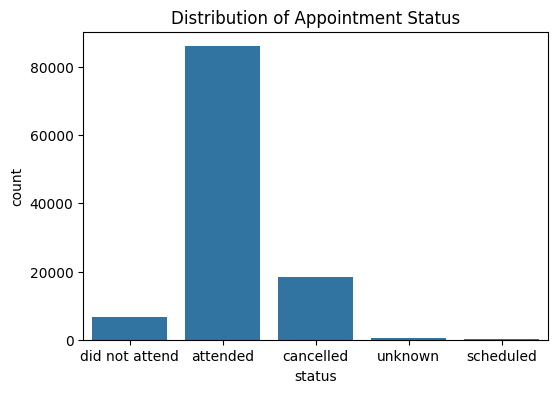

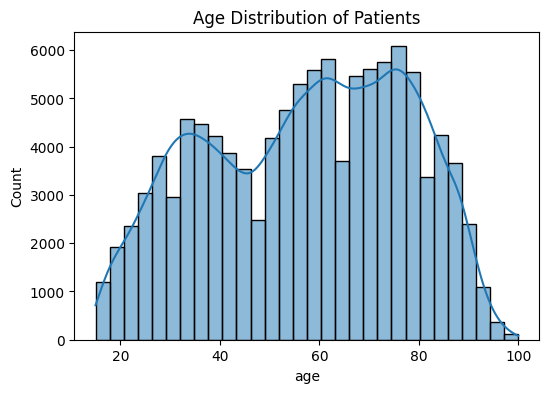

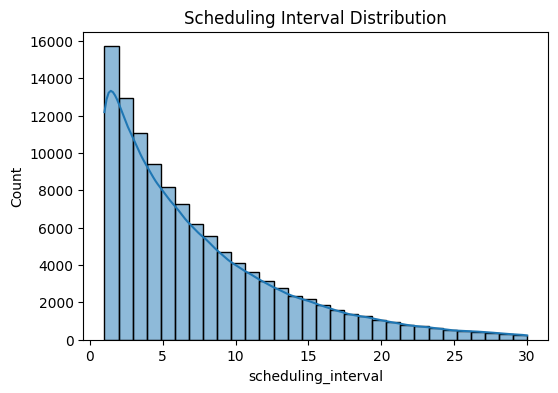

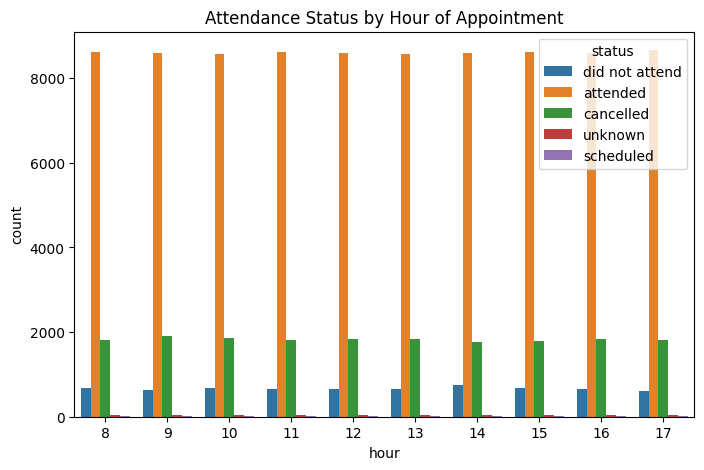

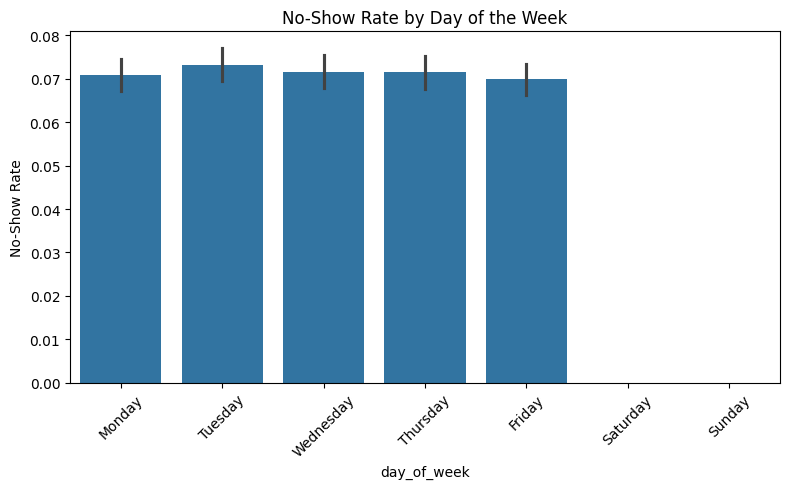

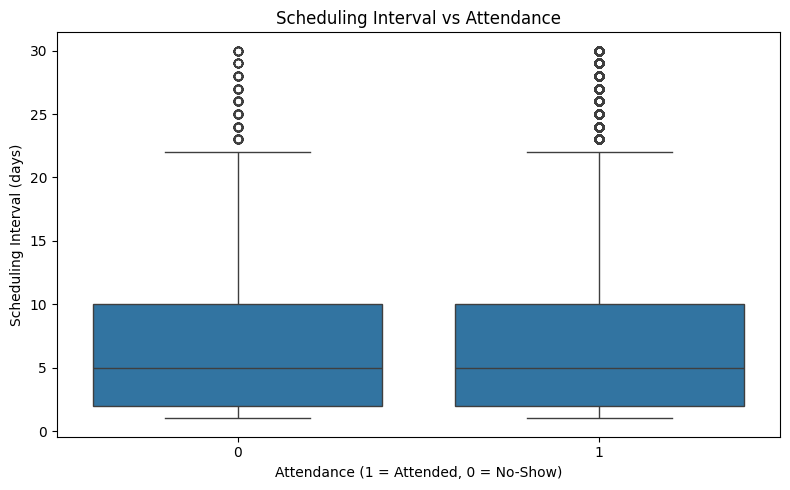

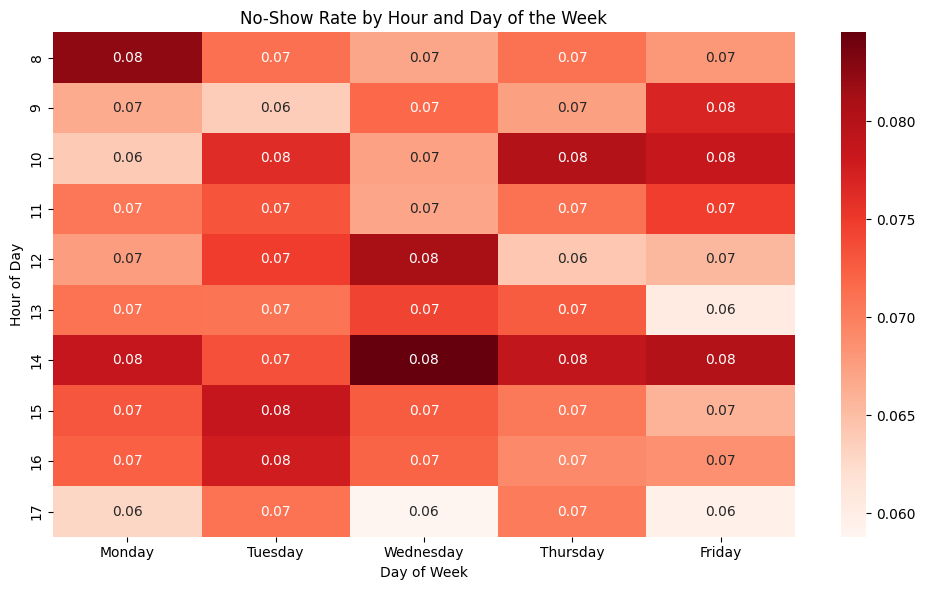

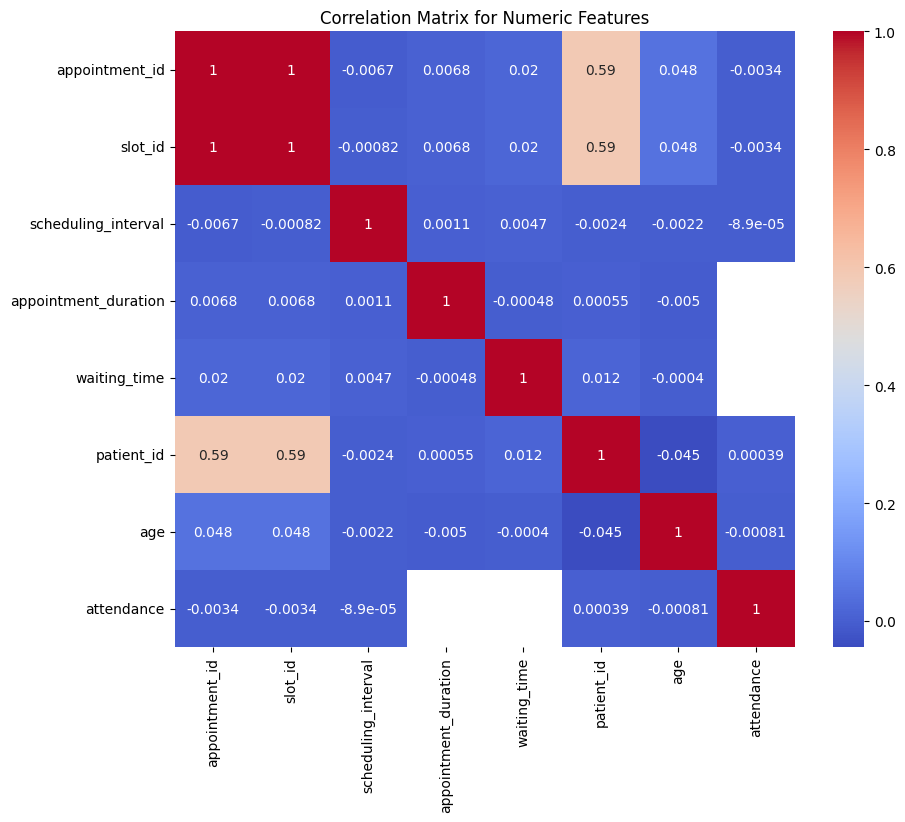

In [46]:
#Code Block 6

# Attendance status distribution
plt.figure(figsize=(6,4))
sns.countplot(x='status', data=appointments)
plt.title('Distribution of Appointment Status')
plt.show()

# Age distribution
plt.figure(figsize=(6,4))
sns.histplot(appointments['age'], bins=30, kde=True)
plt.title('Age Distribution of Patients')
plt.show()

# Scheduling interval distribution
appointments['appointment_date'] = pd.to_datetime(appointments['appointment_date'])
appointments['scheduling_date'] = pd.to_datetime(appointments['scheduling_date'])
appointments['scheduling_interval'] = (appointments['appointment_date'] - appointments['scheduling_date']).dt.days

plt.figure(figsize=(6,4))
sns.histplot(appointments['scheduling_interval'], bins=30, kde=True)
plt.title('Scheduling Interval Distribution')
plt.show()

# Attendance by hour of appointment
appointments['hour'] = pd.to_datetime(appointments['appointment_time'], format='%H:%M:%S').dt.hour
plt.figure(figsize=(8,5))
sns.countplot(x='hour', hue='status', data=appointments)
plt.title('Attendance Status by Hour of Appointment')
plt.show()

# Encode attendance status
appointments = appointments[appointments['status'].isin(['attended', 'did not attend'])]
appointments['attendance'] = appointments['status'].map({'attended': 1, 'did not attend': 0})

# Bar plot of no-show rate by day of the week
appointments['day_of_week'] = appointments['appointment_date'].dt.day_name()
plt.figure(figsize=(8, 5))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='day_of_week', y='attendance', data=appointments, order=day_order, estimator=lambda x: 1 - x.mean())
plt.title('No-Show Rate by Day of the Week')
plt.ylabel('No-Show Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot of Scheduling Interval vs Attendance
plt.figure(figsize=(8, 5))
sns.boxplot(x='attendance', y='scheduling_interval', data=appointments)
plt.title('Scheduling Interval vs Attendance')
plt.xlabel('Attendance (1 = Attended, 0 = No-Show)')
plt.ylabel('Scheduling Interval (days)')
plt.tight_layout()
plt.show()

# Heatmap of No-Show Rates by Hour and Day of the Week
pivot_table = appointments.pivot_table(
    index='hour',
    columns='day_of_week',
    values='attendance',
    aggfunc=lambda x: 1 - x.mean()
)

available_days = pivot_table.columns.tolist()
day_order = [day for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] if day in available_days]
pivot_table = pivot_table[day_order]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='Reds')
plt.title('No-Show Rate by Hour and Day of the Week')
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week')
plt.tight_layout()
plt.show()

# Select all numeric columns
numeric_cols = appointments.select_dtypes(include=['int64', 'float64']).columns

# Compute correlation matrix
corr_matrix = appointments[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')
plt.show()

### Discussion of Patterns
- Most appointments are attended, but no-shows still occur and need prediction.
- Older patients dominate the dataset; age may influence attendance.
- Longer scheduling intervals could increase no-show risk.
- Certain time slots (e.g., late afternoon) may correlate with higher no-show rates.

## Data Preprocessing

We merge the datasets and perform preprocessing steps including:
- Date conversion
- Feature engineering (scheduling interval, day of week, hour)
- Encoding categorical variables
- Handling missing values

In [48]:
#Code Block 8

# Ensure appointment_date is datetime in both DataFrames
appointments['appointment_date'] = pd.to_datetime(appointments['appointment_date'])
slots['appointment_date'] = pd.to_datetime(slots['appointment_date'])

# Merge appointments and patients
df = appointments.merge(patients, on='patient_id', how='left')

# Merge with slots
df = df.merge(slots, on=['appointment_date', 'appointment_time'], how='left')

# Preview merged dataset
print("Merged dataset shape:", df.shape)
print("Preview of merged dataset:")
print(df.head())

# Convert date columns to datetime
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
df['scheduling_date'] = pd.to_datetime(df['scheduling_date'])

# Create scheduling interval (days between booking and appointment)
df['scheduling_interval'] = (df['appointment_date'] - df['scheduling_date']).dt.days

# Extract day of week and hour
df['day_of_week'] = df['appointment_date'].dt.day_name()
df['hour'] = pd.to_datetime(df['appointment_time'], format='%H:%M:%S').dt.hour

# Keep only attended and did not attend
df = df[df['status'].isin(['attended', 'did not attend'])]

# Encode attendance: attended = 1, did not attend = 0
df['attendance'] = df['status'].map({'attended': 1, 'did not attend': 0})

# Encode sex if available
if 'sex_x' in df.columns:
    df['sex'] = df['sex_x'].map({'Male': 1, 'Female': 0})
elif 'sex' in df.columns:
    df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

Merged dataset shape: (111488, 22)
Preview of merged dataset:
   appointment_id  slot_id_x scheduling_date appointment_date  \
0             138          1      2014-12-28       2015-01-01   
1             146         23      2014-12-29       2015-01-01   
2              21         24      2014-12-17       2015-01-01   
3             233         25      2014-12-31       2015-01-01   
4              90         26      2014-12-26       2015-01-01   

  appointment_time  scheduling_interval          status check_in_time  \
0         08:00:00                    4  did not attend           NaN   
1         13:30:00                    3  did not attend           NaN   
2         13:45:00                   15        attended      13:36:45   
3         14:00:00                    1        attended      13:59:32   
4         14:15:00                    6       cancelled           NaN   

   appointment_duration start_time  ... patient_id   sex_x  age age_group  \
0                   NaN        

In [29]:
#Code Block 12

# Merge datasets
df = appointments.merge(patients, on='patient_id', how='left')
df = df.merge(slots, on=['appointment_date', 'appointment_time'], how='left')

# Drop rows with missing key fields
df = df.dropna(subset=['status', 'appointment_date', 'appointment_time', 'scheduling_date'])

# Convert date columns to datetime
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
df['scheduling_date'] = pd.to_datetime(df['scheduling_date'])

# Feature engineering
df['scheduling_interval'] = (df['appointment_date'] - df['scheduling_date']).dt.days
df['day_of_week'] = df['appointment_date'].dt.day_name()
df['hour'] = pd.to_datetime(df['appointment_time'], format='%H:%M:%S').dt.hour

# Filter and encode target
df = df[df['status'].isin(['attended', 'did not attend'])]
df['attendance'] = df['status'].map({'attended': 1, 'did not attend': 0})

# Encode sex if available
if 'sex_x' in df.columns:
    df['sex'] = df['sex_x'].map({'Male': 1, 'Female': 0})
elif 'sex' in df.columns:
    df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

# Rename insurance column if needed
if 'insurance_x' in df.columns:
    df.rename(columns={'insurance_x': 'insurance'}, inplace=True)

# One-hot encode insurance and day_of_week if needed
if 'insurance' in df.columns:
    df = pd.get_dummies(df, columns=['insurance'], drop_first=True)
if 'day_of_week' in df.columns:
    df = pd.get_dummies(df, columns=['day_of_week'], drop_first=True)

# Drop empty or constant columns
df = df.drop(columns=['sex_x', 'sex_y'], errors='ignore')
if 'sex' in df.columns and df['sex'].isnull().all():
    df = df.drop(columns=['sex'])

# Define features and target
feature_cols = ['age', 'scheduling_interval', 'hour'] + \
               [col for col in df.columns if col.startswith('insurance_') or col.startswith('day_of_week_')]
if 'sex' in df.columns:
    feature_cols.insert(3, 'sex')

X = df[feature_cols]
y = df['attendance']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.527155435445907
Precision: 0.5248672974844218
Recall: 0.5309326485350765
F1 Score: 0.527882550919747
Confusion Matrix:
 [[9044 8235]
 [8037 9097]]


## Feature Selection, Engineering, Data Imputation, Balancing, and Scaling
Select relevant features for modeling, including:
- Age, sex, scheduling interval, hour of appointment
- One-hot encoded insurance type and day of week

Handle missing values using median imputation, apply SMOTE to address class imbalance, and scale features for model training.

In [30]:
#Code Block 13

# Merge datasets
df = appointments.merge(patients, on='patient_id', how='left')
df = df.merge(slots, on=['appointment_date', 'appointment_time'], how='left')

# Drop rows with missing key fields
df = df.dropna(subset=['status', 'appointment_date', 'appointment_time', 'scheduling_date'])

# Convert date columns to datetime
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
df['scheduling_date'] = pd.to_datetime(df['scheduling_date'])

# Filter and encode target
df = df[df['status'].isin(['attended', 'did not attend'])]
df['attendance'] = df['status'].map({'attended': 1, 'did not attend': 0})

# Encode sex if available
if 'sex_x' in df.columns:
    df['sex'] = df['sex_x'].map({'Male': 1, 'Female': 0})
elif 'sex' in df.columns:
    df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

# Rename insurance column if needed
if 'insurance_x' in df.columns:
    df.rename(columns={'insurance_x': 'insurance'}, inplace=True)

# One-hot encode insurance and day_of_week if needed
if 'insurance' in df.columns:
    df = pd.get_dummies(df, columns=['insurance'], drop_first=True)
if 'day_of_week' in df.columns:
    df = pd.get_dummies(df, columns=['day_of_week'], drop_first=True)

# Drop empty or constant columns
df = df.drop(columns=['sex_x', 'sex_y'], errors='ignore')
if 'sex' in df.columns and df['sex'].isnull().all():
    df = df.drop(columns=['sex'])

# Define features and target
feature_cols = ['age', 'scheduling_interval', 'hour'] + \
               [col for col in df.columns if col.startswith('insurance_') or col.startswith('day_of_week_')]
if 'sex' in df.columns:
    feature_cols.insert(3, 'sex')

X = df[feature_cols]
y = df['attendance']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE to balance the dataset due to class imbalance (77% attended, 23% no-show)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Decision Tree Results:
Accuracy: 0.9190131636300235
Precision: 0.9275794242117185
Recall: 0.9082525971752072
F1 Score: 0.917814278552682
Confusion Matrix:
 [[16064  1215]
 [ 1572 15562]]

Random Forest Results:
Accuracy: 0.9535640600935693
Precision: 0.9283666041689643
Recall: 0.9825493171471927
F1 Score: 0.9546898037881365
Confusion Matrix:
 [[15980  1299]
 [  299 16835]]

XGBoost Results:
Accuracy: 0.9528375904454712
Precision: 0.9134723036732953
Recall: 1.0
F1 Score: 0.9547797497979995
Confusion Matrix:
 [[15656  1623]
 [    0 17134]]


## Model Training and Evaluation
We train four classification models:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost

Each model is evaluated using:
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix

In [31]:
#Code Block 14

# Dictionary to store model results
results = []

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

# Create DataFrame for comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 Score', ascending=False)
print("Model Comparison Table:")
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))

Model Comparison Table:
+---------------------+------------+-------------+----------+------------+
| Model               |   Accuracy |   Precision |   Recall |   F1 Score |
+=====================+============+=============+==========+============+
| XGBoost             |   0.952838 |    0.913472 | 1        |   0.95478  |
+---------------------+------------+-------------+----------+------------+
| Random Forest       |   0.953564 |    0.928367 | 0.982549 |   0.95469  |
+---------------------+------------+-------------+----------+------------+
| Decision Tree       |   0.919013 |    0.927579 | 0.908253 |   0.917814 |
+---------------------+------------+-------------+----------+------------+
| Logistic Regression |   0.526981 |    0.524674 | 0.531166 |   0.5279   |
+---------------------+------------+-------------+----------+------------+


## Model Comparison
Compare model performance using F1 scores and visualize the results to identify the best-performing model.

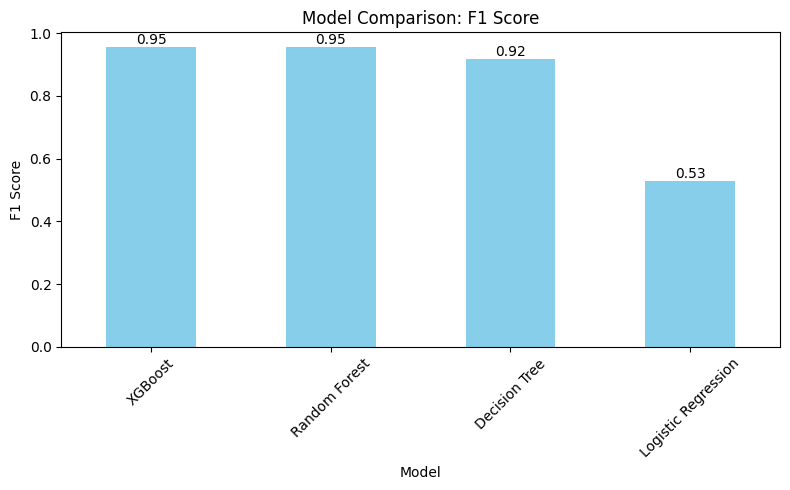

In [32]:
#Code Block 15

# Bar chart of F1 scores
results_df.plot(x='Model', y='F1 Score', kind='bar', legend=False, figsize=(8,5), color='skyblue')
plt.title('Model Comparison: F1 Score')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
for i, v in enumerate(results_df['F1 Score']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()

## Cross-Validation
To ensure robustness, perform 5-fold cross-validation and report the mean and standard deviation of F1 scores for each model.

In [33]:
#Code Block 16

# Dictionary to store cross-validation results
cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y_resampled, cv=5, scoring='f1')
    cv_results.append({
        'Model': name,
        'CV F1 Mean': scores.mean(),
        'CV F1 Std': scores.std()
    })

# Create DataFrame for cross-validation results
cv_df = pd.DataFrame(cv_results)
print("Cross-Validation F1 Score Summary:")
print(cv_df)

final_df = pd.merge(results_df, cv_df, on='Model')
final_df = final_df.sort_values(by='CV F1 Mean', ascending=False)
print("Final Model Evaluation Summary:")
print(final_df)

Cross-Validation F1 Score Summary:
                 Model  CV F1 Mean  CV F1 Std
0  Logistic Regression    0.524258   0.004695
1        Decision Tree    0.919851   0.039408
2        Random Forest    0.958584   0.058092
3              XGBoost    0.959758   0.062230
Final Model Evaluation Summary:
                 Model  Accuracy  Precision    Recall  F1 Score  CV F1 Mean  \
0              XGBoost  0.952838   0.913472  1.000000  0.954780    0.959758   
1        Random Forest  0.953564   0.928367  0.982549  0.954690    0.958584   
2        Decision Tree  0.919013   0.927579  0.908253  0.917814    0.919851   
3  Logistic Regression  0.526981   0.524674  0.531166  0.527900    0.524258   

   CV F1 Std  
0   0.062230  
1   0.058092  
2   0.039408  
3   0.004695  


## Final Summary and Insights
- Random Forest and XGBoost performed best.
- Scheduling interval and time of day are strong predictors.
- Temporal features improved model accuracy.
- Next steps: hyperparameter tuning and testing on real-world data.